In [1]:
import os
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from pypoman import plot_polygon, compute_polytope_halfspaces
from shapely.geometry import MultiPoint
import math as m
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# root folder path
# change the path to the git for your own case
path_prefix = "../"
# hybrid a star
hybrid_path_plan = os.path.abspath(path_prefix + "path_planner/")

# utilis
utils_path = os.path.abspath(path_prefix + "path_planner/utils/")
# obca
obca_path = os.path.abspath(path_prefix + "obca_py/")

sys.path.append(hybrid_path_plan)
sys.path.append(utils_path)
sys.path.append(obca_path)

In [3]:
import map_utils
from OGE_OBCA import orchard_environment_OBCA
from car_model import CarModel
from headland_path_planning import headland_planner_y_type_park_combined
from OBCA_warm_start import get_warm_start_path_dubins, get_warm_start_path_y_type
from safety_forward_path_plan import get_start_end_pose_for_dubins
from optimizer import OBCAOptimizer
from util import wrap_angle, process_angle, get_init_ref_path

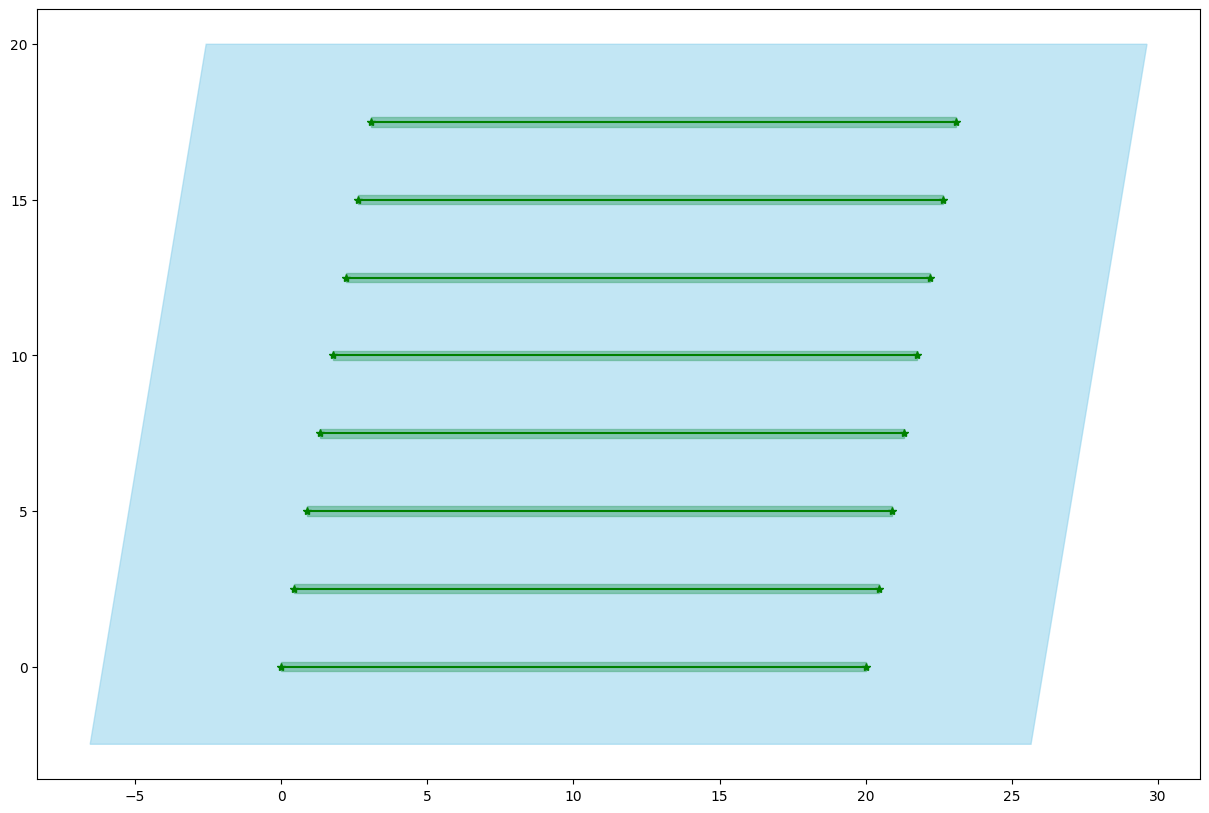

In [4]:
plt.rcParams["figure.figsize"] = [15, 10]

row_width = 2.5
tree_width = 0.3
row_num = 8
row_length = 20
headland_width = 6.0

np.random.seed(1)
tree_rows = map_utils.create_tree_rows(
    row_num, row_width, row_length, slope_angle=m.radians(10), l_std=0.0
)
map_env = orchard_environment_OBCA(
    tree_rows, [], tree_width=tree_width, headland_width=headland_width
)
map_env.plot_field_geometry(plt)
# map_env.contour_points

### Load tractor model

- You can choose different operators

3.098978705155902


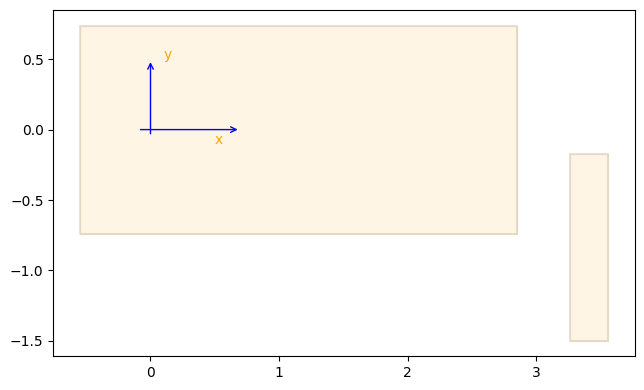

In [6]:
plt.rcParams["figure.figsize"] = [7.5, 4.5]
from car_model import CarModel

# mowing
# aux_poly_features = [[[-1.84, 0.5], 1.0, 1.1]]
# max_backward_distance = 5.0
# max_forward_distance = 2.8
# min_forward_distance = 2.0
# min_backward_distance = 4.0
# enter_offset = 0.0
# exit_offset = 0.0

# summer pruning
aux_poly_features = [[[3.259,-0.175],1.325,0.3]]
max_backward_distance=3.0
max_forward_distance=2.0
min_forward_distance=1.0
min_backward_distance=1.0
enter_offset = 3.66
exit_offset = -1.0

# KMS sprayer
# aux_poly_features = [[[-2.1,1.0/2],1.0,1.22],[[-1.0,4.3/2],0.4,0.5],[[-1.0,-4.3/2+0.4],0.4,0.5]]
# max_backward_distance=5.0
# max_forward_distance=2.5
# min_forward_distance=2.0
# min_backward_distance=4.0
# enter_offset = 0.0
# exit_offset = 0.0


car_with_operator = CarModel(
    max_steer=0.55,
    axle_to_back=0.55,
    width=1.48,
    aux_poly_features=aux_poly_features,
    with_aux=True,
)
empty_car = CarModel(
    max_steer=0.55, axle_to_front=3, axle_to_back=0.55, width=1.48, with_aux=False
)
# empty_car = CarModel(max_steer=0.55,axle_to_front=0.2, axle_to_back=1.2,width=1.48,with_aux=False)
car_poly, auxs = car_with_operator.draw_car(plt, 0, 0, 0)
# empty_car.draw_car(plt,0,0,0)
plt.annotate(
    "", xy=(-0.1, 0), xytext=(0.7, 0), arrowprops=dict(arrowstyle="<-", color="blue")
)
plt.annotate(
    "", xy=(0, -0.05), xytext=(0, 0.5), arrowprops=dict(arrowstyle="<-", color="blue")
)
plt.text(0.5, -0.1, "x", c="orange")
plt.text(0.1, 0.5, "y", c="orange")

# plt.text(1.7, 0.5, 'Object1',c='red')
# plt.text(-1.7, 0.25, 'Object2',c='red')
print(1 / empty_car.curvature)

### Define Enter and Exit poses

(<POLYGON ((-2.667 9.49, -2.667 8.01, 0.733 8.01, 0.733 9.49, -2.667 9.49))>,
 [<POLYGON ((1.142 8.575, 1.442 8.575, 1.442 7.25, 1.142 7.25, 1.142 8.575))>])

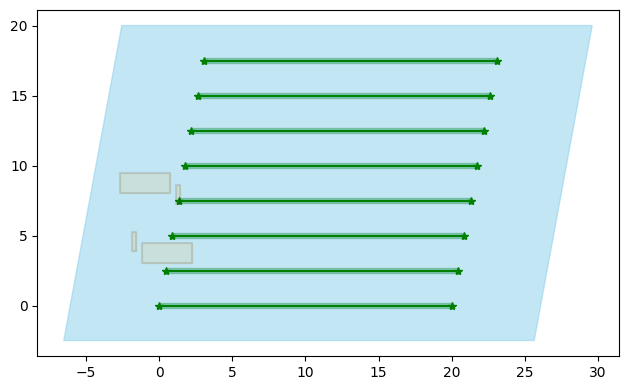

In [7]:
start_row_id = 1
end_row_id = 3
side = map_utils.NEAR_SIDE
start_exit_pose  = map_utils.get_base_pose(start_row_id, tree_rows, exit_offset, side=side, pose_type=map_utils.LEAVE_POSE)
end_enter_pose  = map_utils.get_base_pose(end_row_id, tree_rows, enter_offset, side=side, pose_type=map_utils.ENTER_POSE)
map_env.plot_field_geometry(plt)
car_with_operator.draw_car(plt, start_exit_pose[0],start_exit_pose[1],start_exit_pose[2])
car_with_operator.draw_car(plt, end_enter_pose[0],end_enter_pose[1],end_enter_pose[2])

### Calculate warm start path: 
- y-type path
- forward path

In [8]:
from headland_path_planning import headland_planner_y_type_park_combined
(error_code,path_xs, path_ys, path_yaws, path_ks, dirs) = headland_planner_y_type_park_combined(map_env, empty_car,
                                                                                    start_exit_pose, end_enter_pose,
                                                                                    motion_type="King",
                                                                                    max_steer_backward=0.15,
                                                                                    max_steer_forward=0.55,
                                                                                    max_backward_distance=max_backward_distance,
                                                                                    max_forward_distance=max_forward_distance,
                                                                                    min_forward_distance=min_forward_distance,
                                                                                    min_backward_distance=min_backward_distance,
                                                                                    min_steer_backward=0.0,
                                                                                    min_steer_forward=0.5,
                                                                                    step_size=0.2,
                                                                                    tree_width_in_forward_plan=0.4,
                                                                                    max_steer_for_offset_plan=0.5,)

# print(len(dirs))
# print(len(path_xs))
# print(len(path_ys))
# print(len(path_yaws))
# print(len(path_ks))
if len(path_xs) == 0:
    print("use infeasible path")
    path_xs, path_ys, path_yaws, path_ks, dirs = get_warm_start_path_dubins(empty_car, start_exit_pose, end_enter_pose, step_size=0.1)

backward distance for leaving is 0.00
backward distance for entering is 0.00
start Y park searching
backward distance:1.70, forward distance:2.00, backward steer:0.00, forward steer:0.50,  
hybrid search time:  0.023337841033935547
counter of nodes:  1


### Visualize the generated path from A-star

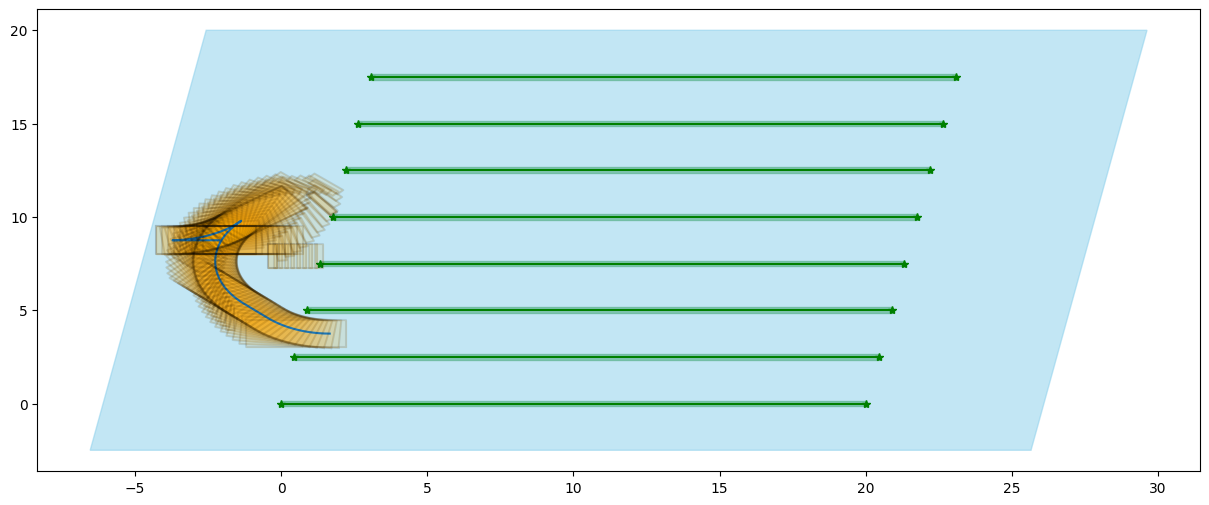

In [10]:
plt.rcParams["figure.figsize"] = [15, 6]
map_env.plot_field_geometry(plt)
plt.plot(path_xs[:], path_ys[:])
for x, y, yaw in zip(path_xs[:], path_ys[:], path_yaws[:]):
    car_with_operator.draw_car(plt, x, y, yaw)

### Express the space with obstacles
- boundary obstacles
- intermediate tree block obstacles

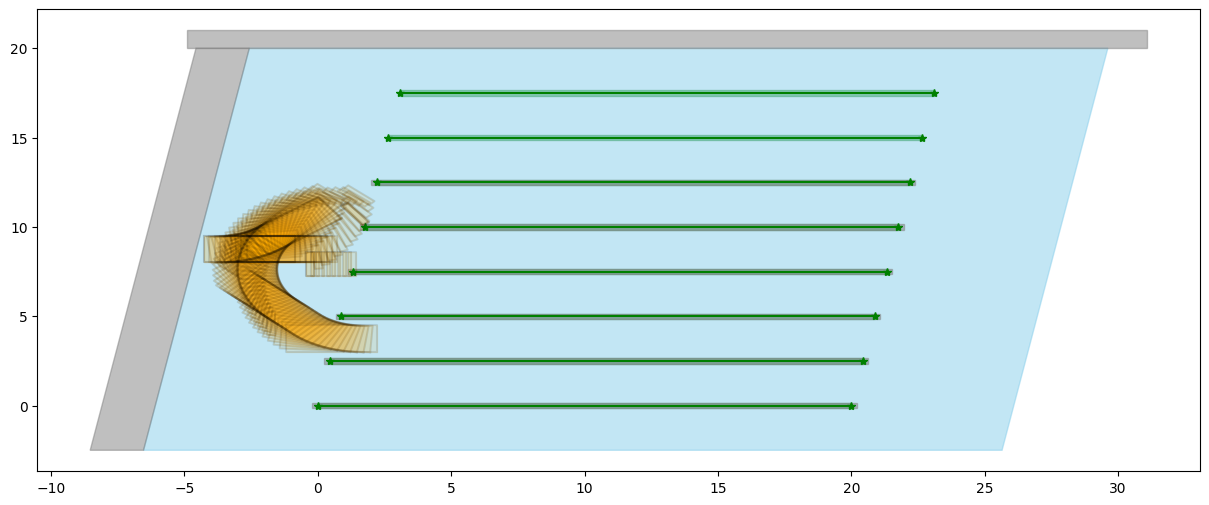

In [11]:
# create obstacles
boundary_polys = map_env.create_boundary_polygons()
row_polys = map_env.get_obstacle_tree_rows(start_exit_pose, end_enter_pose)
obstacles = map_env.get_obstacles_for_OBCA(
    boundary_polys, row_polys, start_exit_pose, end_enter_pose, side=side
)

map_env.plot_field_geometry(plt)
for poly in obstacles:
    plot_polygon(poly, color="gray", alpha=0.5, fill=True)
for x, y, yaw in zip(path_xs[:], path_ys[:], path_yaws[:]):
    car_with_operator.draw_car(plt, x, y, yaw)

### Build up init guess

In [13]:
desired_v = 0.5
dT = 0.4
ds = desired_v*dT
ref_traj = get_init_ref_path(car_with_operator, path_xs, path_ys, path_yaws, path_ks, dirs, desired_v=desired_v, ds=ds)
# ref_traj = np.array([x_opt, y_opt, v_opt, heading_opt, steer_opt]).T
ref_traj.shape

ref_traj[:,3] = process_angle(ref_traj[:,3]) 

### Set up optimizer

In [14]:
# obca optimization
init = time.perf_counter()

Q = np.diag([1, 1]) # accel, steer_rate
R = np.diag([0.1, 0.1]) # speed_jerk, steer_jerk
W = np.diag([10, 0.1]) # path length, total time (total_time penalty = 0 will disable time optimization)

optimizer = OBCAOptimizer(
     car=car_with_operator,
     enable_aux=True,
     obstacles=obstacles,
     init_traj=ref_traj,
     dT=dT,
     Q=Q,
     R=R,
     W=W,
)
print("time to set up: ", time.perf_counter() - init)
init = time.perf_counter()

success, solution = optimizer.solve(max_cpu_time=30, verbose=False)
print("time to solve: ", time.perf_counter() - init)

[OBCA] Prediction steps:  66
[OBCA] Init State =  [ 1.66122618  3.75        0.         -3.14154447  0.        ]
[OBCA] End State =  [-2.11713892  8.75        0.         -6.28318531  0.        ]
[OBCA] The solver has been successfully initialized!
time to set up:  0.21306907000052888
[OBCA] Number of decision variables:  8978
[OBCA] Number of equality constraints:  2447
[OBCA] Number of inequality constraints:  2112
[OBCA] EXIT:  Solve_Succeeded
time to solve:  2.6621944230000736


In [15]:
# state
x_opt = solution["x_opt"]
y_opt = solution["y_opt"]
heading_opt = solution["theta_opt"]
v_opt = solution["v_opt"]
steer_opt = solution["steer_angle_opt"]
# control
a_opt = solution["accel_opt"]
steerate_opt = solution["steer_rate_opt"]
# mu + lambda
mu_opt = solution["mu_opt"]
lambda_opt = solution["lambda_opt"]
# time scale
time_scale_opt = solution["time_scale_opt"]
# print("time_scale: ", time_scale_opt)
time_opt = np.cumsum(time_scale_opt * dT)
time_opt = np.insert(time_opt, 0, 0)

# slack
optimizer.show_slack(solution)
# cost
optimizer.show_cost(solution)

x_slack =  -6.037172453364276e-05
y_slack =  -0.03932670103656483
v_slack =  -0.00021739040238369557
yaw_slack =  -0.1374457828831332
steer_slack =  0.0003368381225011837
Total cost:  131.80104069405814
control effort cost:  5.585718844107804
jerk cost:  0.4061157334946828
path length cost:  21.333515602014867
total time cost:  2.285205464292381
slack cost:  20.43809701002968


### Compare OBCA and Initial Guess

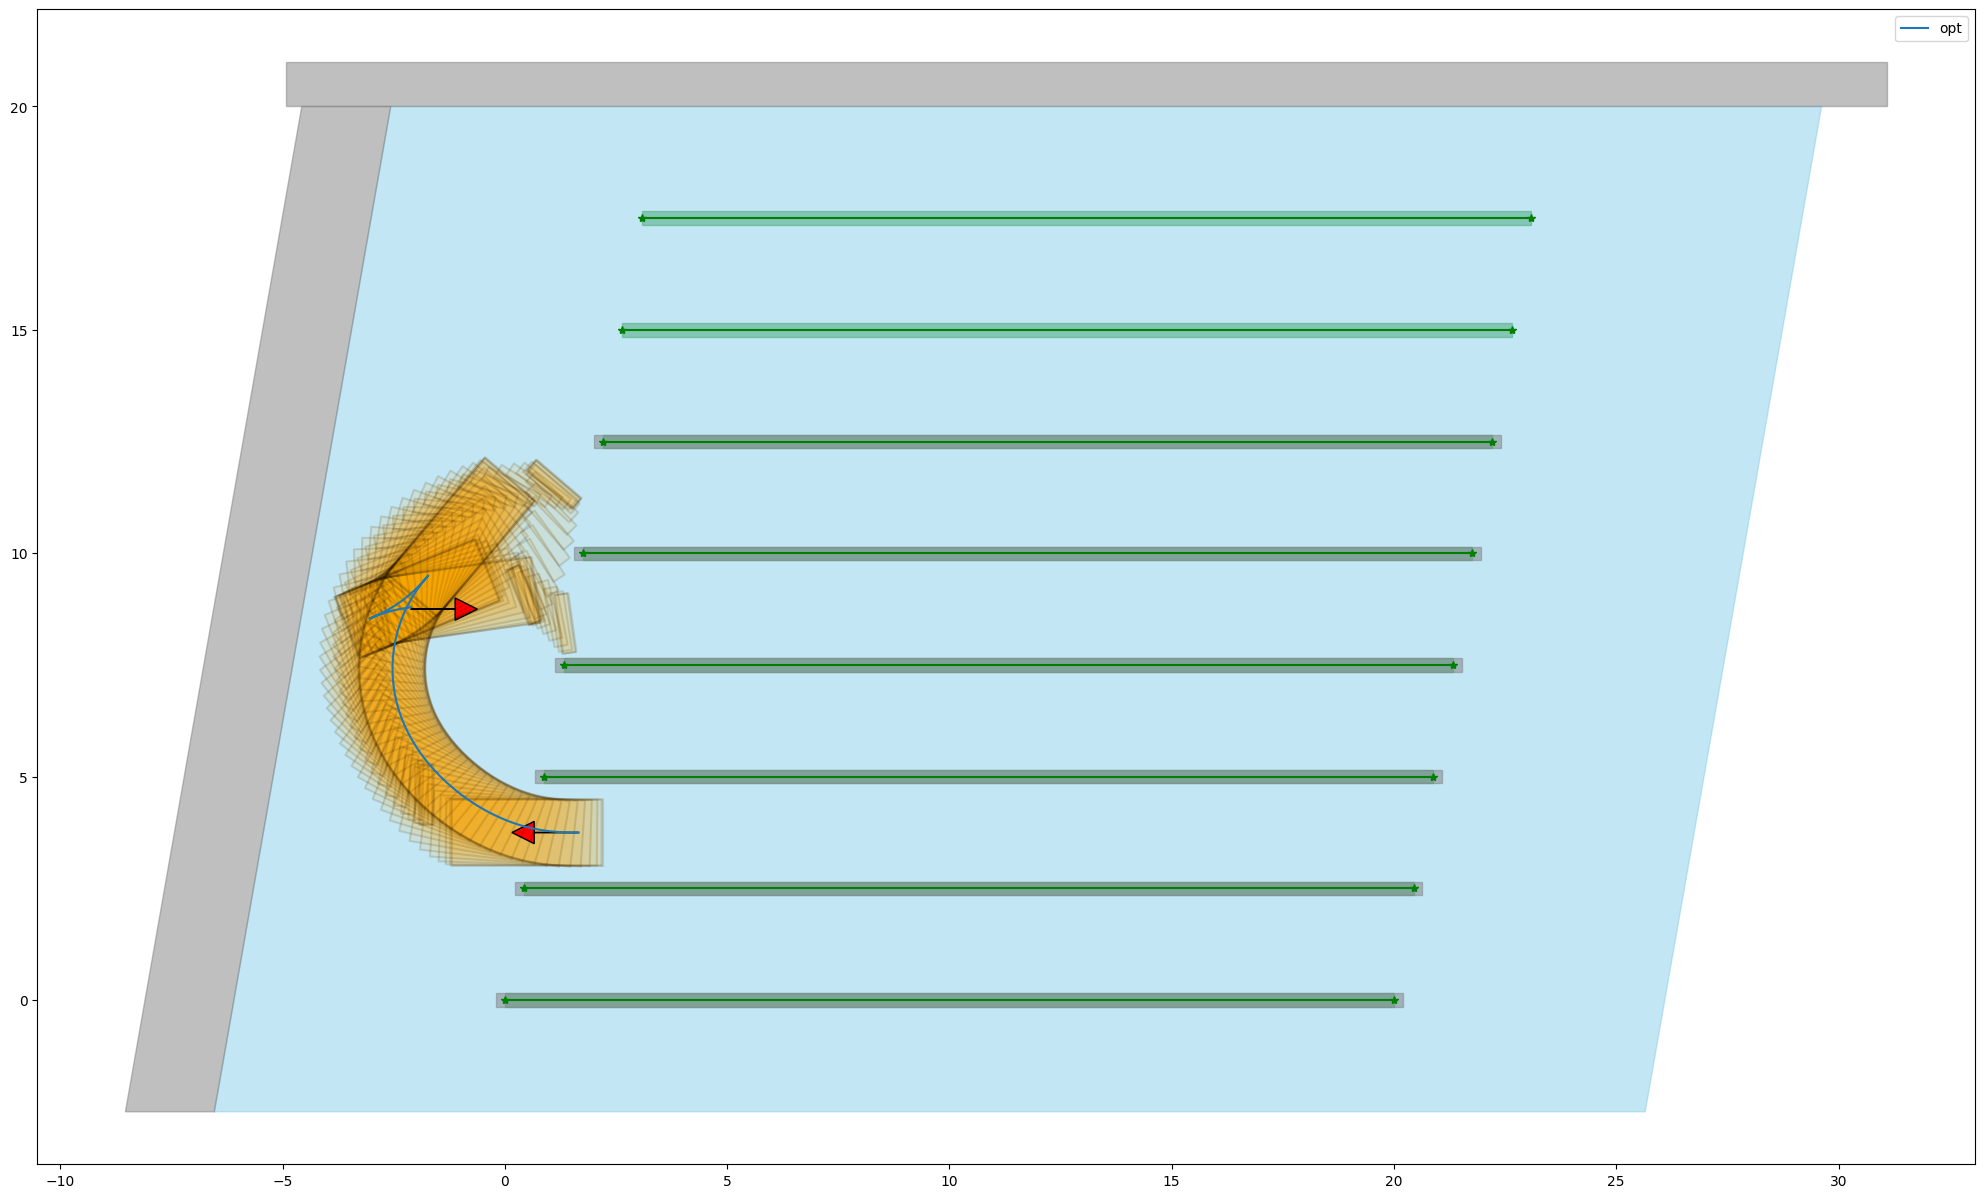

In [17]:
from map_utils import plot_arrow

plt.rcParams["figure.figsize"] = [25, 15]
map_env.plot_field_geometry(plt)

for x, y, yaw in zip(x_opt, y_opt, heading_opt):
    if not map_env.check_path_feasibility(car_with_operator, np.array([[x, y, yaw]])):
        car_with_operator.draw_car(plt, x, y, yaw, color="red", alpha=0.5)
    else:
        car_with_operator.draw_car(plt, x, y, yaw)
    # car_with_operator.draw_car(plt, x,y,yaw)

# plt.plot(path_xs[:],path_ys[:],label='ref')
plt.plot(x_opt, y_opt, label="opt")
# plot_polygon(obstacle_far)
plt.legend()
for poly in obstacles:
    plot_polygon(poly, color="gray", alpha=0.5, fill=True)

plot_arrow(start_exit_pose[0], start_exit_pose[1], start_exit_pose[2], plt)
plot_arrow(end_enter_pose[0], end_enter_pose[1], end_enter_pose[2], plt)

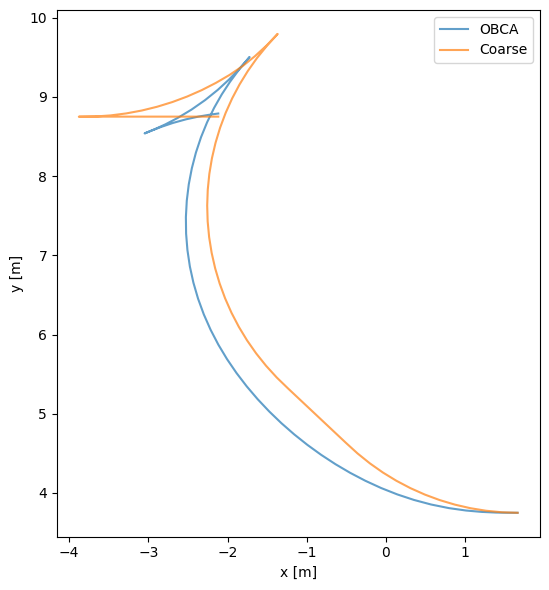

In [18]:
figure, axis = plt.subplots(1, 1, figsize=(6,6))

axis.plot(x_opt, y_opt, alpha=0.7, label='OBCA')
axis.plot(ref_traj[:,0], ref_traj[:,1], alpha=0.7, label='Coarse')
axis.set_aspect(1)
axis.legend()
axis.set_xlabel('x [m]')
axis.set_ylabel('y [m]')

figure.tight_layout()

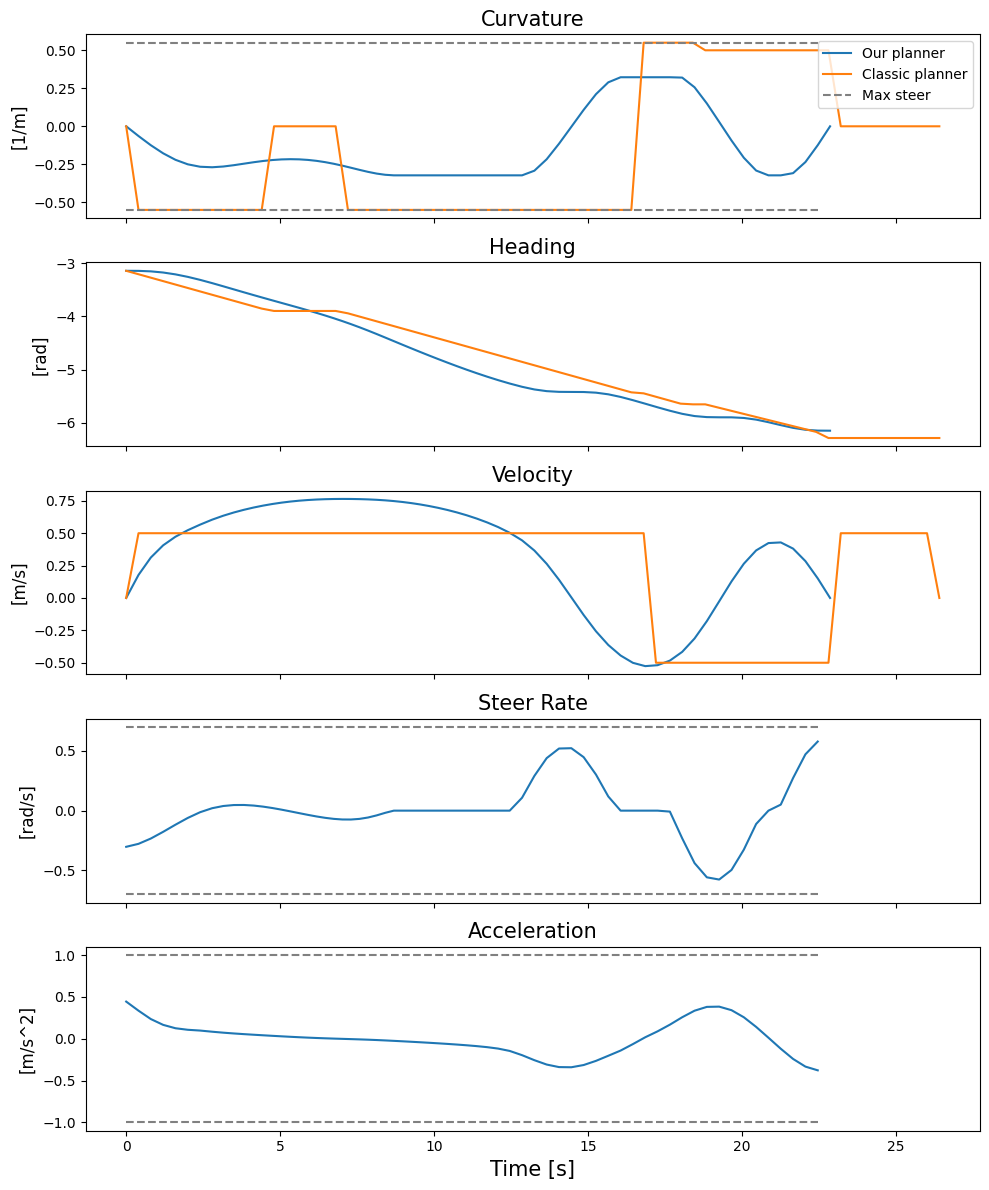

In [19]:
from util import get_init_ref_path_coarse
figure, axes = plt.subplots(5,1, sharex=True, figsize=(10,12))
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = ["Times New Roman"]
# figure, axes = plt.subplots(3,1, sharex=True, figsize=(12,9))
ref_traj = get_init_ref_path_coarse(empty_car, path_xs, path_ys, path_yaws, path_ks, dirs, desired_v=desired_v, ds=ds)

time_coarse = np.arange(0, dT * len(ref_traj), dT)

axes[0].plot(time_opt, np.tan(steer_opt)/empty_car.WHEEL_BASE,label='Our planner')
axes[0].plot(time_coarse, ref_traj[:,-1],label='Classic planner')
axes[0].plot(time_opt[:-1], np.ones_like(time_opt[:-1])*optimizer.MAX_STEER, '--',color='gray')
axes[0].plot(time_opt[:-1], -np.ones_like(time_opt[:-1])*optimizer.MAX_STEER, '--',color='gray',label='Max steer')
axes[0].set_title('Curvature', fontsize=15)
axes[0].set_ylabel('[1/m]', fontsize=12)
axes[0].legend()

axes[1].plot(time_opt, heading_opt, label='Our planner')
axes[1].plot(time_coarse, ref_traj[:,3],label='Classic planner')
axes[1].set_title('Heading', fontsize=15)
axes[1].set_ylabel('[rad]', fontsize=12)
# axes[1].legend()



axes[2].plot(time_opt, v_opt, label='Our planner')
axes[2].plot(time_coarse, ref_traj[:,2],label='Classic planner')
axes[2].set_title('Velocity', fontsize=15)
axes[2].set_ylabel('[m/s]', fontsize=12)
# axes[2].legend()

axes[3].plot(time_opt[:-1], steerate_opt, label='Our planner')
axes[3].plot(time_opt[:-1], np.ones_like(time_opt[:-1])*optimizer.MAX_STEER_RATE, '--',color='gray')
axes[3].plot(time_opt[:-1], -np.ones_like(time_opt[:-1])*optimizer.MAX_STEER_RATE, '--',color='gray',label='Max steer rate')
axes[3].set_title('Steer Rate', fontsize=15)
axes[3].set_ylabel('[rad/s]', fontsize=12)
# axes[3].legend()

axes[4].plot(time_opt[:-1], a_opt, label='Our planner')
axes[4].plot(time_opt[:-1], np.ones_like(time_opt[:-1])*optimizer.MAX_ACCEL, '--',color='gray')
axes[4].plot(time_opt[:-1], -np.ones_like(time_opt[:-1])*optimizer.MAX_ACCEL, '--',color='gray',label='Max acceleration')
axes[4].set_title('Acceleration', fontsize=15)
axes[4].set_ylabel('[m/s^2]', fontsize=12)
axes[4].set_xlabel('Time [s]', fontsize=15)
# axes[4].legend()

figure.tight_layout()